In [1]:
%matplotlib inline


# Comparison of the different over-sampling algorithms


The following example attends to make a qualitative comparison between the
different over-sampling algorithms available in the imbalanced-learn package.




In [2]:
# Authors: Guillaume Lemaitre <g.lemaitre58@gmail.com>
# License: MIT

from collections import Counter

import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_classification
from sklearn.svm import LinearSVC

from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import (SMOTE, BorderlineSMOTE, SVMSMOTE, SMOTENC,
                                    KMeansSMOTE)
from imblearn.over_sampling import RandomOverSampler
from imblearn.base import BaseSampler

print(__doc__)

Using TensorFlow backend.


Automatically created module for IPython interactive environment


The following function will be used to create toy dataset. It using the
``make_classification`` from scikit-learn but fixing some parameters.



In [3]:
def create_dataset(n_samples=1000, weights=(0.01, 0.01, 0.98), n_classes=3,
                   class_sep=0.8, n_clusters=1):
    return make_classification(n_samples=n_samples, n_features=2,
                               n_informative=2, n_redundant=0, n_repeated=0,
                               n_classes=n_classes,
                               n_clusters_per_class=n_clusters,
                               weights=list(weights),
                               class_sep=class_sep, random_state=0)

The following function will be used to plot the sample space after resampling
to illustrate the characterisitic of an algorithm.



In [4]:
def plot_resampling(X, y, sampling, ax):
    X_res, y_res = sampling.fit_resample(X, y)
    ax.scatter(X_res[:, 0], X_res[:, 1], c=y_res, alpha=0.8, edgecolor='k')
    # make nice plotting
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    return Counter(y_res)

The following function will be used to plot the decision function of a
classifier given some data.



In [5]:
def plot_decision_function(X, y, clf, ax):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, edgecolor='k')

Illustration of the influence of the balancing ratio
##############################################################################



We will first illustrate the influence of the balancing ratio on some toy
data using a linear SVM classifier. Greater is the difference between the
number of samples in each class, poorer are the classfication results.



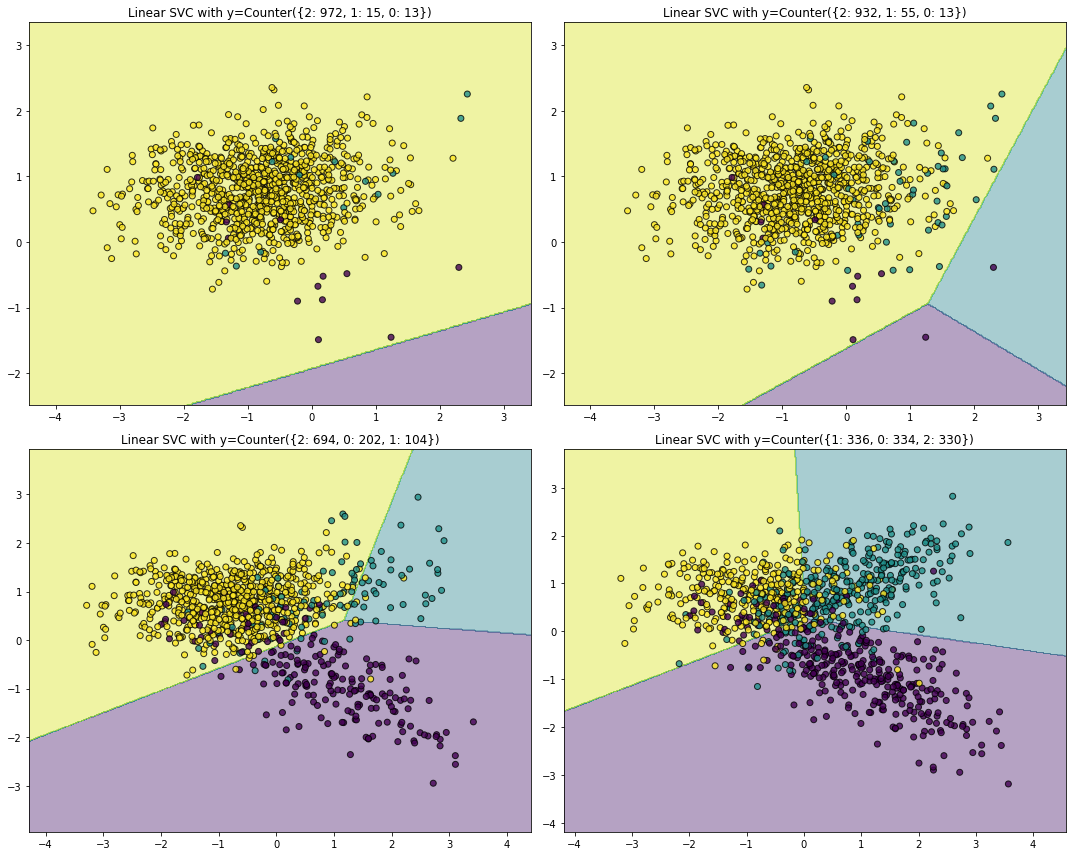

In [6]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

ax_arr = (ax1, ax2, ax3, ax4)
weights_arr = ((0.01, 0.01, 0.98), (0.01, 0.05, 0.94),
               (0.2, 0.1, 0.7), (0.33, 0.33, 0.33))
for ax, weights in zip(ax_arr, weights_arr):
    X, y = create_dataset(n_samples=1000, weights=weights)
    clf = LinearSVC().fit(X, y)
    plot_decision_function(X, y, clf, ax)
    ax.set_title('Linear SVC with y={}'.format(Counter(y)))
fig.tight_layout()

Random over-sampling to balance the data set
##############################################################################



Random over-sampling can be used to repeat some samples and balance the
number of samples between the dataset. It can be seen that with this trivial
approach the boundary decision is already less biaised toward the majority
class.



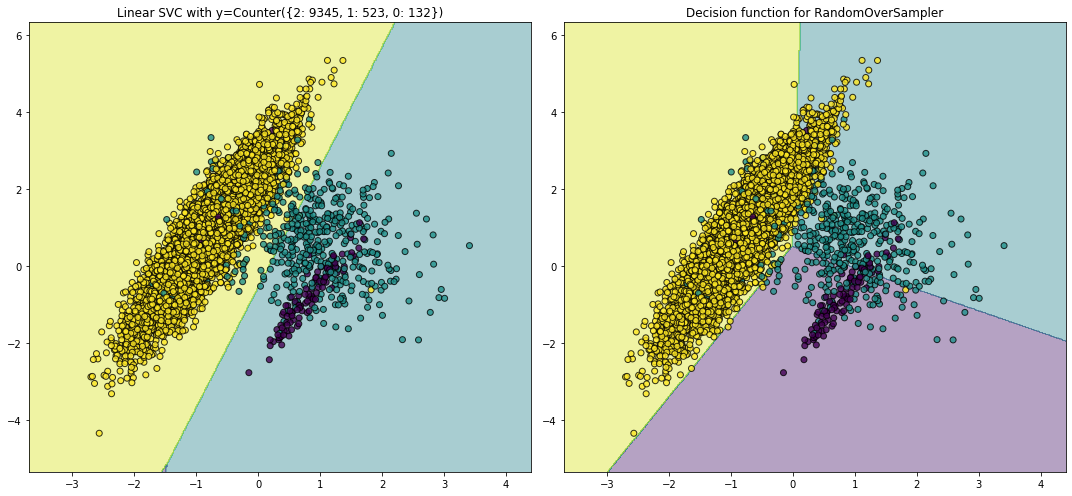

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
X, y = create_dataset(n_samples=10000, weights=(0.01, 0.05, 0.94))
clf = LinearSVC().fit(X, y)
plot_decision_function(X, y, clf, ax1)
ax1.set_title('Linear SVC with y={}'.format(Counter(y)))
pipe = make_pipeline(RandomOverSampler(random_state=0), LinearSVC())
pipe.fit(X, y)
plot_decision_function(X, y, pipe, ax2)
ax2.set_title('Decision function for RandomOverSampler')
fig.tight_layout()

More advanced over-sampling using ADASYN and SMOTE
##############################################################################



Instead of repeating the same samples when over-sampling, we can use some
specific heuristic instead. ADASYN and SMOTE can be used in this case.



In [ ]:
# Make an identity sampler
class FakeSampler(BaseSampler):

    _sampling_type = 'bypass'

    def _fit_resample(self, X, y):
        return X, y


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))
X, y = create_dataset(n_samples=10000, weights=(0.01, 0.05, 0.94))
sampler = FakeSampler()
clf = make_pipeline(sampler, LinearSVC())
plot_resampling(X, y, sampler, ax1)
ax1.set_title('Original data - y={}'.format(Counter(y)))

ax_arr = (ax2, ax3, ax4)
for ax, sampler in zip(ax_arr, (RandomOverSampler(random_state=0),
                                SMOTE(random_state=0),
                                ADASYN(random_state=0))):
    clf = make_pipeline(sampler, LinearSVC())
    clf.fit(X, y)
    plot_resampling(X, y, sampler, ax)
    ax.set_title('Resampling using {}'.format(sampler.__class__.__name__))
fig.tight_layout()

The following plot illustrate the difference between ADASYN and SMOTE. ADASYN
will focus on the samples which are difficult to classify with a
nearest-neighbors rule while regular SMOTE will not make any distinction.
Therefore, the decision function depending of the algorithm.



In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
X, y = create_dataset(n_samples=10000, weights=(0.01, 0.05, 0.94))

clf = LinearSVC().fit(X, y)
plot_decision_function(X, y, clf, ax1)
ax1.set_title('Linear SVC with y={}'.format(Counter(y)))
sampler = SMOTE()
clf = make_pipeline(sampler, LinearSVC())
clf.fit(X, y)
plot_decision_function(X, y, clf, ax2)
ax2.set_title('Decision function for {}'.format(sampler.__class__.__name__))
sampler = ADASYN()
clf = make_pipeline(sampler, LinearSVC())
clf.fit(X, y)
plot_decision_function(X, y, clf, ax3)
ax3.set_title('Decision function for {}'.format(sampler.__class__.__name__))
fig.tight_layout()

Due to those sampling particularities, it can give rise to some specific
issues as illustrated below.



In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))
X, y = create_dataset(n_samples=5000, weights=(0.01, 0.05, 0.94),
                      class_sep=0.8)

ax_arr = ((ax1, ax2), (ax3, ax4))
for ax, sampler in zip(ax_arr, (SMOTE(random_state=0),
                                ADASYN(random_state=0))):
    clf = make_pipeline(sampler, LinearSVC())
    clf.fit(X, y)
    plot_decision_function(X, y, clf, ax[0])
    ax[0].set_title('Decision function for {}'.format(
        sampler.__class__.__name__))
    plot_resampling(X, y, sampler, ax[1])
    ax[1].set_title('Resampling using {}'.format(
        sampler.__class__.__name__))
fig.tight_layout()

SMOTE proposes several variants by identifying specific samples to consider
during the resampling. The borderline version will detect which point to
select which are in the border between two classes. The SVM version will use
the support vectors found using an SVM algorithm to create new sample while
the KMeans version will make a clustering before to generate samples in each
cluster independently depending each cluster density.



In [ ]:
fig, ((ax1, ax2), (ax3, ax4),
      (ax5, ax6), (ax7, ax8),
      (ax9, ax10)) = plt.subplots(5, 2, figsize=(15, 30))
X, y = create_dataset(n_samples=5000, weights=(0.01, 0.05, 0.94),
                      class_sep=0.8)


ax_arr = ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10))
for ax, sampler in zip(ax_arr,
                       (SMOTE(random_state=0),
                        BorderlineSMOTE(random_state=0, kind='borderline-1'),
                        BorderlineSMOTE(random_state=0, kind='borderline-2'),
                        KMeansSMOTE(random_state=0),
                        SVMSMOTE(random_state=0))):
    clf = make_pipeline(sampler, LinearSVC())
    clf.fit(X, y)
    plot_decision_function(X, y, clf, ax[0])
    ax[0].set_title('Decision function for {}'.format(
        sampler.__class__.__name__))
    plot_resampling(X, y, sampler, ax[1])
    ax[1].set_title('Resampling using {}'.format(sampler.__class__.__name__))
fig.tight_layout()

When dealing with a mixed of continuous and categorical features, SMOTE-NC
is the only method which can handle this case.



In [ ]:
# create a synthetic data set with continuous and categorical features
rng = np.random.RandomState(42)
n_samples = 50
X = np.empty((n_samples, 3), dtype=object)
X[:, 0] = rng.choice(['A', 'B', 'C'], size=n_samples).astype(object)
X[:, 1] = rng.randn(n_samples)
X[:, 2] = rng.randint(3, size=n_samples)
y = np.array([0] * 20 + [1] * 30)

print('The original imbalanced dataset')
print(sorted(Counter(y).items()))
print('The first and last columns are containing categorical features:')
print(X[:5])

smote_nc = SMOTENC(categorical_features=[0, 2], random_state=0)
X_resampled, y_resampled = smote_nc.fit_resample(X, y)
print('Dataset after resampling:')
print(sorted(Counter(y_resampled).items()))
print('SMOTE-NC will generate categories for the categorical features:')
print(X_resampled[-5:])

plt.show()